# Intepretable models

The easiest method to achieve model interpretability is to employ an **interpretable model**. 

The easiest, most-widely-known method, the "hello world" of the machine learning world is the **Linear Regression**. It is readily interpretable via the values of the weights. The linear nature of the model and the independence of the features allow for comprehensive explanations.

Another obvious choice is the **Decision Tree**. A person can simply follow the path along the leaves to reach to the conclusion. He/She can also reason about the steps needed to diverge from the path and land in an alternative prediction. 

We will review these two models in the notebook below.

Other interpretable models include:
* Logistic Regression
* Decision Rules
* Naive Bayes
* K-nearest Neighbours

Please see [The Interpretable ML book](https://christophm.github.io/interpretable-ml-book/simple.html) for more details.

In [3]:
import pandas as pd
%reload_ext autoreload
%autoreload 2

# Linear Regression

Linear Regression is the "*hello world*" of the ML world. It as a very simple model which learns a feature weight $w_i$ for each input feature $x_i$.

$$ pred = \sum_iw_i*x_i + b$$

There is no interaction between the features and the prediction changes linearly with every input feature. These properties lend to straightforward explanations.

In [25]:
data = pd.read_csv("../data/deputat_daily_features.csv").dropna()
data.head()

,Unnamed: 0,deputat,party,present,date,Year,Month,Week,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,present_last_ass,present_last_5ass
5,5,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-24,2019,1,4,24,3,False,False,False,False,False,False,0.0,0.6
6,6,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-25,2019,1,4,25,4,False,False,False,False,False,False,0.0,0.4
7,7,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-30,2019,1,5,30,2,False,False,False,False,False,False,0.0,0.4
8,8,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-31,2019,1,5,31,3,True,False,False,False,False,False,0.0,0.2
9,9,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-02-01,2019,2,5,1,4,False,True,False,False,False,False,0.0,0.0


In order to accomodate the Linear Regression, we need to turn our categorical features into one-hot encoded features.

In [33]:
numerical_features = ['present_last_ass', 'present_last_5ass']
categorical_features = ['party']

features_df = data[numerical_features].copy()

for cat_feat in categorical_features:
    dummies = pd.get_dummies(data[cat_feat], prefix=cat_feat)
    display(f"dummy for {cat_feat} is {dummies.columns[0]}")
    dummies = dummies.drop(columns=dummies.columns[:1])
    features_df = pd.concat([features_df, dummies],axis=1)

    
features_df['bias'] = 1
features_df.head()


'dummy for party is party_ВОЛЯ'

,present_last_ass,present_last_5ass,party_ГЕРБ,party_ДПС,party_НЕЗ,party_ОП,party_ПГБСП,bias
5,0.0,0.6,0,1,0,0,0,1
6,0.0,0.4,0,1,0,0,0,1
7,0.0,0.4,0,1,0,0,0,1
8,0.0,0.2,0,1,0,0,0,1
9,0.0,0.0,0,1,0,0,0,1


The importance of each feature is measured by the weight of the feature, divided by the standard error for the feature:

$$importance_i = \frac{w_i}{SE_i}$$

To calculate the standard errors, we can use the **statsmodels** package. 

In [39]:
from statsmodels.api import OLS, Logit

In [40]:
model = OLS(data['present'].values, features_df, hasconst=True)

The **statsmodels** results have a convenient `summary2()` method which lists various statistics about the model. We are most interested in the `Coef.` and `Std.Err` for each feature.

In [44]:
results = model.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.305     
Dependent Variable: y                AIC:                37690.0358
Date:               2020-06-06 11:16 BIC:                37757.7209
No. Observations:   34914            Log-Likelihood:     -18837.   
Df Model:           7                F-statistic:        2193.     
Df Residuals:       34906            Prob (F-statistic): 0.00      
R-squared:          0.305            Scale:              0.17229   
-------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-------------------------------------------------------------------
present_last_ass      0.1313   0.0064 20.4287 0.0000  0.1187 0.1438
present_last_5ass     0.5961   0.0089 67.0159 0.0000  0.5787 0.6135
party_ГЕРБ            0.0183   0.0105  1.7355 0.0827 -0.0024 0.0390
party_ДПС            -0.0206   0.0121 -1.7038 0.0884 -0.0443 0.0031
party_НЕЗ            -0.0034   0.0181 -0.1856 0.8527 -0.0389 0.0322
party_ОП              0.0490   0.0122  4.0011 0.0001  0.0250 0.0729
party_ПГБСП          -0.0196   0.0107 -1.8412 0.0656 -0.0406 0.0013
bias                  0.1443   0.0105 13.7624 0.0000  0.1238 0.1649
-------------------------------------------------------------------
Omnibus:             1133.920       Durbin-Watson:          2.028  
Prob(Omnibus):       0.000          Jarque-Bera (JB):       727.775
Skew:                -0.227         Prob(JB):               0.000  
Kurtosis:            2.457          Condition No.:          16     
===================================================================

"""

The table is a great way to drill down into the exact coefficients, but sometimes it is neccessary to take a higher-level look. 
This is when the **weight plot** comes into play. For each feature, we visualize the feature value as well as the 95% confidence interval. This reminds us that our model is an approximation and there is underlying uncertainty.

In [45]:
from interpretable_models import weight_plot, effect_plot, effect_plot_for_example

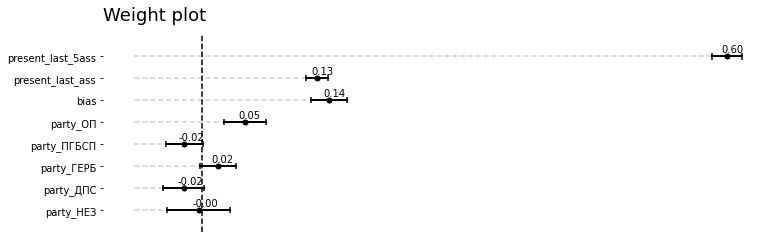

In [46]:
%matplotlib inline
weight_plot(results, score='t')


Another useful visualization is the **effect plot**. 

For every feature, we calculate the effect $w_i*x_i$ for every example in the dataset and visualize the 2.5, 50 and 97.5 percentiles of the resulting values. This way we can see the interaction between the range of the feature values and the coefficients.

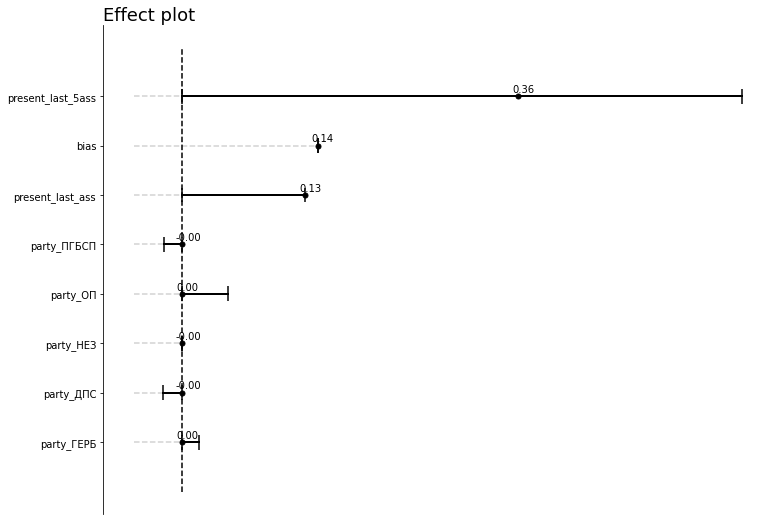

In [60]:
effect_plot(results, features_df);

The nice thing about effect plots is that they make it easy to compare an individual example to the rest in the dataset.

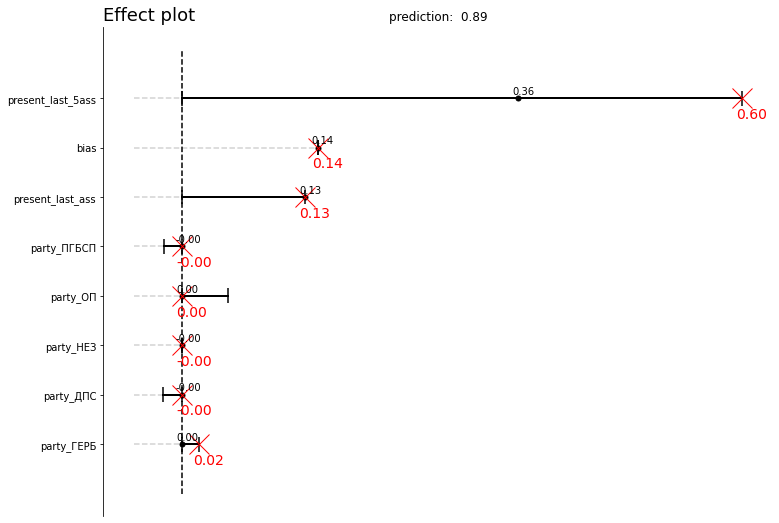

In [66]:
random_example = np.random.randint(0, len(features_df))
effect_plot_for_example(results, features_df, features_df.iloc[random_example])

# Decision Trees

Decision trees are the next obvious choice for an interpretable model. One simply needs to follow the leaves to understand the reasoning of the machine.

In [73]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
%matplotlib inline


In [74]:
tree = DecisionTreeRegressor(max_depth=3)
model =  tree.fit(features_df, data['present'])

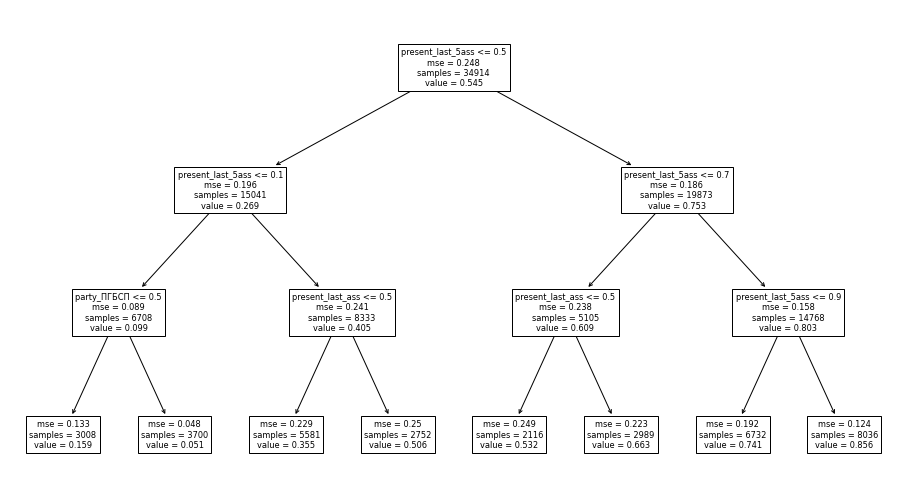

In [76]:
fig, ax =plt.subplots(figsize=(16,9))
plot_tree(model, ax=ax, feature_names=features_df.columns);